<a href="https://colab.research.google.com/github/mdpw/msc-ir-code/blob/main/Session%2012/Tumor_prediction_with_image_Masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models


In [7]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"dineshwijesuriya","key":"8776f70bd89384ed6e56df475e598805"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip


Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [10]:
import os
import shutil

base_dir = "lgg-mri-segmentation/kaggle_3m"
image_out = "images"
mask_out  = "masks"

os.makedirs(image_out, exist_ok=True)
os.makedirs(mask_out, exist_ok=True)

for patient in os.listdir(base_dir):
    patient_dir = os.path.join(base_dir, patient)
    if not os.path.isdir(patient_dir):
        continue

    for file in os.listdir(patient_dir):
        src = os.path.join(patient_dir, file)

        if file.endswith(".tif") and "_mask" in file:
            shutil.copy(src, os.path.join(mask_out, file))
        elif file.endswith(".tif"):
            shutil.copy(src, os.path.join(image_out, file))

print("Images:", len(os.listdir(image_out)))
print("Masks :", len(os.listdir(mask_out)))


Images: 3929
Masks : 3929


In [11]:
import os
import cv2
import numpy as np

IMG_SIZE = 128

def load_data(image_dir, mask_dir):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_dir))

    for file in image_files:
        img_path  = os.path.join(image_dir, file)
        mask_path = os.path.join(mask_dir, file.replace(".tif", "_mask.tif"))

        # Read files
        img  = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 🔴 SAFETY CHECK (THIS FIXES YOUR ERROR)
        if img is None or mask is None:
            continue

        img  = cv2.resize(img,  (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        images.append(img)
        masks.append(mask)

    images = np.array(images, dtype=np.float32) / 255.0
    masks  = np.array(masks,  dtype=np.float32) / 255.0

    return images[..., np.newaxis], masks[..., np.newaxis]



In [12]:
X, y = load_data("images", "masks")
print(X.shape, y.shape)



(3929, 128, 128, 1) (3929, 128, 128, 1)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

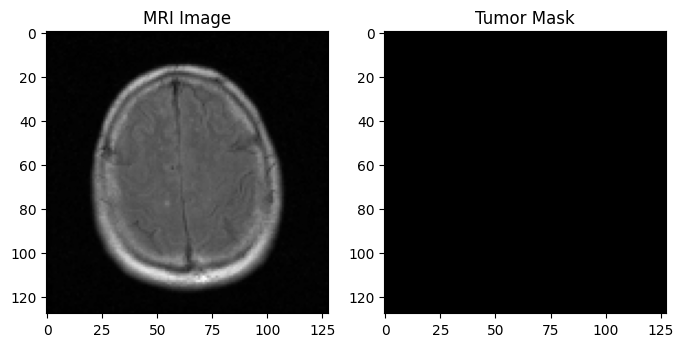

In [14]:
idx = 10
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("MRI Image")
plt.imshow(X[idx].squeeze(), cmap='gray')

plt.subplot(1,2,2)
plt.title("Tumor Mask")
plt.imshow(y[idx].squeeze(), cmap='gray')

plt.show()


In [15]:
def unet():
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 1))

    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    return models.Model(inputs, outputs)


In [16]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / \
               (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [17]:
model = unet()
model.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=8,
    validation_split=0.1
)


Epoch 1/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8423 - loss: 0.8885 - val_accuracy: 0.9884 - val_loss: 0.9225
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9890 - loss: 0.9741 - val_accuracy: 0.9884 - val_loss: 0.9225
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9889 - loss: 0.9671 - val_accuracy: 0.9884 - val_loss: 0.9225
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9886 - loss: 0.9819 - val_accuracy: 0.9884 - val_loss: 0.9225
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9885 - loss: 0.9830 - val_accuracy: 0.9884 - val_loss: 0.9225
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9887 - loss: 0.9853 - val_accuracy: 0.9884 - val_loss: 0.9225
Epoch 7/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9889 - loss: 0.9835 - val_accuracy: 0.9884 - val_loss: 0.9225
Epoch 8/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9891 - loss: 0.9389 - val_acc

In [18]:
pred = model.predict(X_test)

idx = 1
plt.figure(figsize=(10,4))




25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step


<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

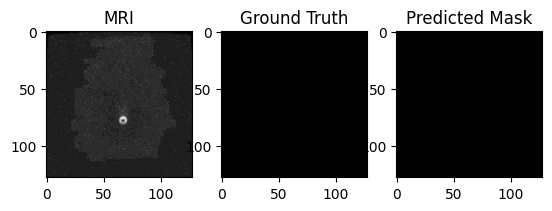

In [19]:
plt.subplot(1,3,1)
plt.title("MRI")
plt.imshow(X_test[idx].squeeze(), cmap='gray')

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(y_test[idx].squeeze(), cmap='gray')

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred[idx].squeeze() > 0.5, cmap='gray')

plt.show()